<a href="https://colab.research.google.com/github/rmiclark/SIADS-592-StreamingVid-Analytics/blob/main/nftWallet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook Setup

In [ ]:
import warnings
warnings.filterwarnings(action='once')
try:
  import requests
  import pymysql
  import sqlalchemy
  from google.cloud.sql.connector import connector
  from getpass import getpass
  from flask import g, current_app
  import tqdm
  import pyLDAvis.gensim_models
except:
  ! python -m pip install pymysql
  ! python -m pip install cloud-sql-python-connector[pg8000]
  ! python -m pip install urllib3
  ! python -m pip install getpass
  ! python -m pip install flask
  ! python -m pip install tqdm
  ! python -m pip install pyLDAvis

import os
import pandas as pd
import json
import urllib.request
import requests
import pymysql
import sqlalchemy
from google.cloud.sql.connector import connector
import time
import numpy as np
import collections
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import altair as alt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cdist
from scipy import stats
import psycopg2
from psycopg2 import extras, pool
import tqdm
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from datetime import datetime
from gensim.test.utils import common_corpus, common_dictionary
from gensim import models
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis.gensim_models


In [ ]:
# mount drive where CSV data files live
drive.mount('/content/drive')
try:
  os.chdir('drive/MyDrive/gotham_data')
  os.listdir()
except:
  os.listdir()

Mounted at /content/drive


### DB Connector's and DB Data Load
- used for build, hashed-out for reproduceability (CSV data files)

In [ ]:
# load .json credentials for Google service --- upload .json from downloads local folder to colab instance
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "opensea-333804-f005233a666e.json"

# # create connection to Mike's GCP PG database
# def getconn() -> pymysql.connections.Connection:
#   conn: pymysql.connections.Connection = connector.connect("opensea-333804:us-west1:opensea","pg8000",user="postgres",password="Thor2020!",db="postgres")
#   return conn

# pool = sqlalchemy.create_engine("postgresql+pg8000://",creator=getconn)

In [ ]:
# create connection to Sahil's AZ PG database
connection_pool = psycopg2.pool.SimpleConnectionPool(1, 20, user="nftrecadmin",
                                            password="An*L61&bIf%NAdRY2Ij^ph7#F4SyIg1R",
                                            host="nft-rec-697.postgres.database.azure.com",
                                            port="5432",
                                            database="siads697")
def add_connection_to_pool(conn):
    try:
        connection_pool.putconn(conn)
    except:
        print("Had issue putting conn back")
def get_db_connection():
    return connection_pool.getconn()

1. NFT Event Data Load (Postgres DB)
  - *used for generating a list of wallet_addresses to build and test recommender system*

In [ ]:
# # load data from postgres tables into dataframe
# df = pd.DataFrame()
# for table_name in ['os_data_event_rb','os_data_event']:
#   data_SQL = "SELECT approved_account,asset_bundle,auction_type,bid_amount,collection_slug,contract_address,created_date,custom_event_name,dev_fee_payment_event,dev_seller_fee_basis_points,duration,ending_price,event_type,id,is_private,owner_account,quantity,seller,starting_price,to_account,total_price,transaction,winner_account,listing_time,asset_id,asset_num_sales,asset_background_color,asset_image_url,asset_image_preview_url,asset_image_thumbnail_url,asset_image_original_url,asset_animation_url,asset_animation_original_url,asset_name,asset_description,asset_external_link,asset_asset_contract_address,asset_asset_contract_asset_contract_type,asset_asset_contract_created_date,asset_asset_contract_name,asset_asset_contract_nft_version,asset_asset_contract_opensea_version,asset_asset_contract_owner,asset_asset_contract_schema_name,asset_asset_contract_symbol,asset_asset_contract_total_supply,asset_asset_contract_description,asset_asset_contract_external_link,asset_asset_contract_image_url,asset_asset_contract_default_to_fiat,asset_asset_contract_dev_buyer_fee_basis_points,asset_asset_contract_dev_seller_fee_basis_points,asset_asset_contract_only_proxied_transfers,asset_asset_contract_opensea_buyer_fee_basis_points,asset_asset_contract_opensea_seller_fee_basis_points,asset_asset_contract_buyer_fee_basis_points,asset_asset_contract_seller_fee_basis_points,asset_asset_contract_payout_address,asset_permalink,asset_collection_banner_image_url,asset_collection_chat_url,asset_collection_created_date,asset_collection_default_to_fiat,asset_collection_description,asset_collection_dev_buyer_fee_basis_points,asset_collection_dev_seller_fee_basis_points,asset_collection_discord_url,asset_collection_display_data_card_display_style,asset_collection_external_url,asset_collection_featured,asset_collection_featured_image_url,asset_collection_hidden,asset_collection_safelist_request_status,asset_collection_image_url,asset_collection_is_subject_to_whitelist,asset_collection_large_image_url,asset_collection_medium_username,asset_collection_name,asset_collection_only_proxied_transfers,asset_collection_opensea_buyer_fee_basis_points,asset_collection_opensea_seller_fee_basis_points,asset_collection_payout_address,asset_collection_require_email,asset_collection_short_description,asset_collection_slug,asset_collection_telegram_url,asset_collection_twitter_username,asset_collection_instagram_username,asset_collection_wiki_url,asset_decimals,asset_token_metadata,asset_owner_user_username,asset_owner_profile_img_url,asset_owner_address,asset_owner_config,asset_token_id,from_account_user_username,from_account_profile_img_url,from_account_address,from_account_config,payment_token_id,payment_token_symbol,payment_token_address,payment_token_image_url,payment_token_name,payment_token_decimals,payment_token_eth_price,payment_token_usd_price FROM {}".format(table_name)
#   data = []
#   with pool.connect() as db_conn:
#     # get  data from table
#     data_payload = db_conn.execute('{}'.format(data_SQL)).fetchall()
#     for row in data_payload:
#       data.append(row)

#   col_names = ['approved_account','asset_bundle','auction_type','bid_amount','collection_slug','contract_address','created_date','custom_event_name','dev_fee_payment_event','dev_seller_fee_basis_points','duration','ending_price','event_type','id','is_private','owner_account','quantity','seller','starting_price','to_account','total_price','transaction','winner_account','listing_time','asset_id','asset_num_sales','asset_background_color','asset_image_url','asset_image_preview_url','asset_image_thumbnail_url','asset_image_original_url','asset_animation_url','asset_animation_original_url','asset_name','asset_description','asset_external_link','asset_asset_contract_address','asset_asset_contract_asset_contract_type','asset_asset_contract_created_date','asset_asset_contract_name','asset_asset_contract_nft_version','asset_asset_contract_opensea_version','asset_asset_contract_owner','asset_asset_contract_schema_name','asset_asset_contract_symbol','asset_asset_contract_total_supply','asset_asset_contract_description','asset_asset_contract_external_link','asset_asset_contract_image_url','asset_asset_contract_default_to_fiat','asset_asset_contract_dev_buyer_fee_basis_points','asset_asset_contract_dev_seller_fee_basis_points','asset_asset_contract_only_proxied_transfers','asset_asset_contract_opensea_buyer_fee_basis_points','asset_asset_contract_opensea_seller_fee_basis_points','asset_asset_contract_buyer_fee_basis_points','asset_asset_contract_seller_fee_basis_points','asset_asset_contract_payout_address','asset_permalink','asset_collection_banner_image_url','asset_collection_chat_url','asset_collection_created_date','asset_collection_default_to_fiat','asset_collection_description','asset_collection_dev_buyer_fee_basis_points','asset_collection_dev_seller_fee_basis_points','asset_collection_discord_url','asset_collection_display_data_card_display_style','asset_collection_external_url','asset_collection_featured','asset_collection_featured_image_url','asset_collection_hidden','asset_collection_safelist_request_status','asset_collection_image_url','asset_collection_is_subject_to_whitelist','asset_collection_large_image_url','asset_collection_medium_username','asset_collection_name','asset_collection_only_proxied_transfers','asset_collection_opensea_buyer_fee_basis_points','asset_collection_opensea_seller_fee_basis_points','asset_collection_payout_address','asset_collection_require_email','asset_collection_short_description','asset_collection_slug','asset_collection_telegram_url','asset_collection_twitter_username','asset_collection_instagram_username','asset_collection_wiki_url','asset_decimals','asset_token_metadata','asset_owner_user_username','asset_owner_profile_img_url','asset_owner_address','asset_owner_config','asset_token_id','from_account_user_username','from_account_profile_img_url','from_account_address','from_account_config','payment_token_id','payment_token_symbol','payment_token_address','payment_token_image_url','payment_token_name','payment_token_decimals','payment_token_eth_price','payment_token_usd_price']
#   df_rb = pd.DataFrame(data=data, columns = col_names)
#   df = pd.concat([df,df_rb])
#   time.sleep(30)
# df.shape

2. NFT Wallet Data Load (Postgres DB)
  - *used to build and test NFT recommender system in DEV*

In [ ]:
# load wallet data from PG database
# table_name = 'os_wallet_data'
# data_SQL = "SELECT * FROM {} WHERE event_type in ('successful','created')".format(table_name)
# data = []
# with pool.connect() as db_conn:
#   # get  data from table
#   data_payload = db_conn.execute('{}'.format(data_SQL)).fetchall()
#   for row in data_payload:
#     data.append(row)
# col_names = ['asset_id', 'asset_num_sales', 'asset_image_url', 'asset_image_preview_url', 'asset_image_thumbnail_url', 'asset_image_original_url', 'asset_name', 'asset_description', 'asset_asset_contract_address', 'asset_asset_contract_asset_contract_type', 'asset_asset_contract_created_date', 'asset_asset_contract_name', 'asset_asset_contract_nft_version', 'asset_asset_contract_owner', 'asset_asset_contract_schema_name', 'asset_asset_contract_symbol', 'asset_asset_contract_total_supply', 'asset_asset_contract_description', 'asset_asset_contract_external_link', 'asset_asset_contract_image_url', 'asset_asset_contract_default_to_fiat', 'asset_asset_contract_dev_buyer_fee_basis_points', 'asset_asset_contract_dev_seller_fee_basis_points', 'asset_asset_contract_only_proxied_transfers', 'asset_asset_contract_opensea_buyer_fee_basis_points', 'asset_asset_contract_opensea_seller_fee_basis_points', 'asset_asset_contract_buyer_fee_basis_points', 'asset_asset_contract_seller_fee_basis_points', 'asset_asset_contract_payout_address', 'asset_permalink', 'asset_collection_banner_image_url', 'asset_collection_created_date', 'asset_collection_default_to_fiat', 'asset_collection_description', 'asset_collection_dev_buyer_fee_basis_points', 'asset_collection_dev_seller_fee_basis_points', 'asset_collection_discord_url', 'asset_collection_display_data_card_display_style', 'asset_collection_external_url', 'asset_collection_featured', 'asset_collection_featured_image_url', 'asset_collection_hidden', 'asset_collection_safelist_request_status', 'asset_collection_image_url', 'asset_collection_is_subject_to_whitelist', 'asset_collection_large_image_url', 'asset_collection_name', 'asset_collection_only_proxied_transfers', 'asset_collection_opensea_buyer_fee_basis_points', 'asset_collection_opensea_seller_fee_basis_points', 'asset_collection_payout_address', 'asset_collection_require_email', 'asset_collection_slug', 'asset_collection_twitter_username', 'asset_collection_instagram_username', 'asset_collection_is_nsfw', 'asset_decimals', 'asset_token_metadata', 'asset_is_nsfw', 'asset_owner_user_username', 'asset_owner_profile_img_url', 'asset_owner_address', 'asset_token_id', 'collection_slug', 'contract_address', 'created_date', 'event_type', 'from_account_user_username', 'from_account_profile_img_url', 'from_account_address', 'id', 'is_private', 'quantity', 'to_account_user_username', 'to_account_profile_img_url', 'to_account_address', 'transaction_block_hash', 'transaction_block_number', 'transaction_from_account_user_username', 'transaction_from_account_profile_img_url', 'transaction_from_account_address', 'transaction_id', 'transaction_timestamp', 'transaction_to_account_profile_img_url', 'transaction_to_account_address', 'transaction_transaction_hash', 'transaction_transaction_index', 'listing_time', 'payment_token_id', 'payment_token_symbol', 'payment_token_address', 'payment_token_image_url', 'payment_token_name', 'payment_token_decimals', 'payment_token_eth_price', 'payment_token_usd_price', 'seller_user_username', 'seller_profile_img_url', 'seller_address', 'wallet_address', 'timestmp']
# w_df = pd.DataFrame(data=data, columns = col_names)

3. NFT Trait Data Load (Postgres DB)
  - *used to build and test NFT recommender system in DEV*

In [ ]:
# function for getting trait data from Sahil's AZ DB
def get_asset_data_for_tokens():
    """
    Get drilled down data for given asset token IDs
    :param asset_tokens: asset token IDs
    :return: asset data needed by the frontend
    """
    conn = get_db_connection()
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    cur.execute("""
        WITH asset_records AS (SELECT * from asset_catalog_v2)
        SELECT *
        FROM asset_records p
        LEFT JOIN asset_traits_v2 c
        USING (asset_token_id)
        """)
    trait_rows = cur.fetchall()

    return pd.DataFrame(trait_rows)
trait_df = get_asset_data_for_tokens()

### CSV Data Load
- replace DB conn's with CSV file

In [ ]:
# NFT wallet data set load
w_df = pd.read_csv('nft_wallet_data.csv',error_bad_lines=True)
print('total records in dataset: {}'.format(len(w_df)))

total records in dataset: 563665


In [ ]:
print("number of NFTs with traits in dataset: {}".format(trait_df.asset_token_id.nunique()))

number of NFTs with traits in dataset: 26820


### NFT Wallet Data Processing & Feature Engineering
- used to build model for classifying wallet type and generating intuition on right number of wallet owner types

In [ ]:
# rebuild asset_num_sales from prior str cleaning resulting in decimal replacement with whitespace
w_df['asset_num_sales'].fillna('0', inplace = True)
w_df['asset_num_sales'] = w_df['asset_num_sales'].str.replace('nan','0').apply(lambda x: int(str(x).split(' ')[0]))
# rebuild payment_token_usd_price from prior str cleaning resulting in decimal replacement with whitespace
w_df['payment_token_usd_price'].fillna('0', inplace = True)
w_df['payment_token_usd_price'] = w_df['payment_token_usd_price'].str.replace('None','0').str.replace('nan','0').apply(lambda x: int(str(x).split(' ')[0]))

w_df['token_id_contract_address'] = w_df['asset_token_id'] + w_df['asset_asset_contract_address'] 
print('unique NFTs + contracts in the dataset: {}'.format(w_df['token_id_contract_address'].nunique()))
print('unique wallets in the dataset: {}'.format(w_df['wallet_address'].nunique()))
print('total records in dataset: {}'.format(len(w_df)))

unique NFTs + contracts in the dataset: 205344
unique wallets in the dataset: 3214
total records in dataset: 563665


In [ ]:
# randomly sample an NFT wallet
pd.set_option('display.max_columns',250)
w_df[w_df.wallet_address == w_df.wallet_address.sample().values[0]].head(1)

,Unnamed: 0,asset_id,asset_num_sales,asset_image_url,asset_image_preview_url,asset_image_thumbnail_url,asset_image_original_url,asset_name,asset_description,asset_asset_contract_address,asset_asset_contract_asset_contract_type,asset_asset_contract_created_date,asset_asset_contract_name,asset_asset_contract_nft_version,asset_asset_contract_owner,asset_asset_contract_schema_name,asset_asset_contract_symbol,asset_asset_contract_total_supply,asset_asset_contract_description,asset_asset_contract_external_link,asset_asset_contract_image_url,asset_asset_contract_default_to_fiat,asset_asset_contract_dev_buyer_fee_basis_points,asset_asset_contract_dev_seller_fee_basis_points,asset_asset_contract_only_proxied_transfers,asset_asset_contract_opensea_buyer_fee_basis_points,asset_asset_contract_opensea_seller_fee_basis_points,asset_asset_contract_buyer_fee_basis_points,asset_asset_contract_seller_fee_basis_points,asset_asset_contract_payout_address,asset_permalink,asset_collection_banner_image_url,asset_collection_created_date,asset_collection_default_to_fiat,asset_collection_description,asset_collection_dev_buyer_fee_basis_points,asset_collection_dev_seller_fee_basis_points,asset_collection_discord_url,asset_collection_display_data_card_display_style,asset_collection_external_url,asset_collection_featured,asset_collection_featured_image_url,asset_collection_hidden,asset_collection_safelist_request_status,asset_collection_image_url,asset_collection_is_subject_to_whitelist,asset_collection_large_image_url,asset_collection_name,asset_collection_only_proxied_transfers,asset_collection_opensea_buyer_fee_basis_points,asset_collection_opensea_seller_fee_basis_points,asset_collection_payout_address,asset_collection_require_email,asset_collection_slug,asset_collection_twitter_username,asset_collection_instagram_username,asset_collection_is_nsfw,asset_decimals,asset_token_metadata,asset_is_nsfw,asset_owner_user_username,asset_owner_profile_img_url,asset_owner_address,asset_token_id,collection_slug,contract_address,created_date,event_type,from_account_user_username,from_account_profile_img_url,from_account_address,id,is_private,quantity,to_account_user_username,to_account_profile_img_url,to_account_address,transaction_block_hash,transaction_block_number,transaction_from_account_user_username,transaction_from_account_profile_img_url,transaction_from_account_address,transaction_id,transaction_timestamp,transaction_to_account_profile_img_url,transaction_to_account_address,transaction_transaction_hash,transaction_transaction_index,listing_time,payment_token_id,payment_token_symbol,payment_token_address,payment_token_image_url,payment_token_name,payment_token_decimals,payment_token_eth_price,payment_token_usd_price,seller_user_username,seller_profile_img_url,seller_address,wallet_address,timestmp,token_id_contract_address
516708,516708,352727812 0,3,https lh3 googleusercontent com KN5dB CnbCH1JD...,https lh3 googleusercontent com KN5dB CnbCH1JD...,https lh3 googleusercontent com KN5dB CnbCH1JD...,ipfs bafybeibjunqygiccbh5xqzbed5tz3xyvsmgc5rfk...,Sprite 6322,Sprite Club is a collection of 7 777 Sprites s...,0x2744fe5e7776bca0af1cdeaf3ba3d1f5cae515d3,non fungible,2022 03 22T23 29 56 862447,SpriteClub,3 0,75379255 0,ERC721,SPRITE,0,Sprite Club is a collection of 7 777 Sprites m...,https spriteclubnft com,https lh3 googleusercontent com QJ O9Uzdmh7CIB...,False,0 0,750 0,False,0 0,250 0,0 0,1000 0,0x28193082de8f789d1ed103cfd841c1715713c264,https opensea io assets 0x2744fe5e7776bca0af1c...,https lh3 googleusercontent com Be JrBFnyBK3Kt...,2022 03 25T11 28 29 708988,False,Sprite Club is a collection of 7 777 Sprites m...,0.0,750.0,None,cover,https spriteclubnft com,False,https lh3 googleusercontent com us08eLTBG GI32...,False,approved,https lh3 googleusercontent com QJ O9Uzdmh7CIB...,False,https lh3 googleusercontent com us08eLTBG GI32...,Sprite Club Official,False,0.0,250.0,0x28193082de8f789d1ed103cfd841c1715713c264,False,spriteclub,None,None,False,0 0,https op

Wallet feature engineering: we hypothesize some combination of these features might enable wallet profiling / clustering to drive a more precise recommender logic based on wallet characterization
- Total unique NFTS held
- Total NFTs purchased, and % of total held
- Total NFTs minted, and % of total held
- Total NFTs sold, and % of total held 
- Count of unique collections held
- Count of the max collection holding
- Count of min collection holding
- Count of mean collection holdering
- Average of NFT volume for NFTs in the wallet
- Median of NFT volume for NFTs in the wallet
- Min of NFT volume for NFTs in the wallet
- Max of NFT volume for NFTs in the wallet

In [ ]:
# feature creation / wallet data aggregation (per the above)
total_nft_held = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_token_id'].nunique()
total_nft_transacted = w_df[w_df.event_type == 'successful'].groupby('wallet_address')['asset_token_id'].nunique()
total_nft_sale = w_df[(w_df.seller_address == w_df.wallet_address)].groupby('wallet_address')['asset_token_id'].nunique()
unique_collections_held = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['collection_slug'].nunique()
max_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.max}).reset_index().set_index('wallet_address')
min_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.min}).reset_index().set_index('wallet_address')
avg_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.mean}).reset_index().set_index('wallet_address')
avg_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].mean()
median_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].median()
min_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].min()
max_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].max()
avg_eth_usd_price = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address']).agg({'payment_token_usd_price':np.mean})

In [ ]:
# feature dataframe representation
features = {
'total_nft_held':total_nft_held,'total_nft_transacted':total_nft_transacted,
 'total_nft_sale':total_nft_sale,'unique_collections_held':unique_collections_held,
 'max_collection_count':max_collection_count,'min_collection_count':min_collection_count,'avg_collection_count':avg_collection_count,
 'avg_nft_vol':avg_nft_vol,'median_nft_vol':median_nft_vol,'min_nft_vol':min_nft_vol,'max_nft_vol':max_nft_vol,'avg_eth_usd_price':avg_eth_usd_price
}
feature_df = pd.DataFrame(columns=['wallet_address'], data = total_nft_held.index).set_index('wallet_address')

for k,v in features.items():
  try:
    features[k].name = features[k].name.replace(features[k].name,'{}'.format(k))
  except:
    features[k].rename(columns={str(features[k].columns[0]):'{}'.format(k)}, inplace=True)
  feature_df = pd.merge(feature_df,features[k], how='left',left_index=True,right_index=True)

feature_df['total_nft_sale'] = feature_df['total_nft_sale'].fillna(0)
feature_df['nft_churn'] = feature_df['total_nft_transacted'] / feature_df['total_nft_held']
feature_df['nft_sale_pct_transacted'] = feature_df['total_nft_sale'] / feature_df['total_nft_transacted']
feature_df['colletion_spread'] = feature_df['max_collection_count'] - feature_df['min_collection_count']

In [ ]:
# Remove high transaction volume wallets as these are indicative of robotic / systemic transactions and therefore unlikely to be good candidates for a recommender system; 
# similar for wallets containing > n number of NFTs

n_transacted = 500
n_held = 500
n_churn = 100 # ratio of transacted / held
feature_df = feature_df[(feature_df['total_nft_transacted'] < n_transacted)&(feature_df['total_nft_held'] < n_held)&(feature_df['nft_churn'] < n_churn)]

### NFT Wallet Exploratory Data Analysis
- Visualize the wallet NFT distributions of the count of NFT transactions, count of NFTs held and unique NFT collections held for insights into global wallet composition
- Analyze relationships between variables to identify relevant characteristics of wallet holders. For example, do wallets with high transaction volumes tend to focus on a particular collection or are they broad-based / diversified?  

In [ ]:
feature_df.describe()

NameError: ignored

In [ ]:
stdDevs = 3
model_vars = feature_df.copy()
# add upper and lower bounds to df for histogram visualization, based on above std devs param

fields = ['total_nft_transacted','total_nft_held','unique_collections_held']
for field in fields:
  model_vars['{}_lower'.format(field)] = model_vars['{}'.format(field)] - (np.std(model_vars['{}'.format(field)]) * stdDevs)
  model_vars['{}_upper'.format(field)] = model_vars['{}'.format(field)] + (np.std(model_vars['{}'.format(field)]) * stdDevs)

base_chart = alt.Chart(model_vars)
#distribution of total_nfts_transacted with std deviations per above variable
nft_trans_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("total_nft_transacted:Q", bin=alt.Bin(extent=[0, 200], step=50)), y='count()')
trans_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(total_nft_transacted):Q',title='Total NFTs Transacted (+/- {} Standard Deviations)'.format(stdDevs)))
trans_histogram = nft_trans_bar + trans_mean 
trans_histogram = trans_histogram.properties(width=600,height=560)

# distribution of total_nft_held with std deviations per above variable
nft_held_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("total_nft_held:Q", bin=True), y='count()').interactive()
held_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(total_nft_held):Q',title="Total NFTs Held (+/- {} Standard Deviations)".format(stdDevs)))
held_histogram = nft_held_bar + held_mean
held_histogram = held_histogram.properties(width=450,height=250)

# distribution of word counts with std deviations per above variable
colls_held_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("unique_collections_held:Q", bin=True), y='count()').interactive()
colls_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(unique_collections_held):Q',title="Unique Collections Held (+/- {} Standard Deviations)".format(stdDevs)))
colls_histogram = colls_held_bar + colls_mean
colls_histogram = colls_histogram.properties(width=450,height=250)

held_mets = alt.vconcat(held_histogram,colls_histogram)
alt.hconcat(trans_histogram,held_mets)

In [ ]:
# view a pair-plot / scatter plot matrix of the wallet features
sns.set_theme(style="ticks")
sns.pairplot(feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','nft_churn']])

In [ ]:
x = feature_df['unique_collections_held']
y = feature_df['total_nft_held']

sns.jointplot(x, y, kind="reg")
print('R2 value: {}'.format(stats.pearsonr(x, y)[0] ** 2))

In [ ]:
n = 50
x2 = feature_df[feature_df['total_nft_held']< n]['unique_collections_held']
y2 = feature_df[feature_df['total_nft_held']< n]['total_nft_held']

sns.jointplot(x2, y2, kind="reg", color='orange')
print('R2 value: {}'.format(stats.pearsonr(x2, y2)[0] ** 2))

### NFT Wallet Clustering Model (Unsupervised) Build & Evaluation
- k-means model build
- optimal cluster evaluation
- cluster labeling analysis

In [ ]:
X = feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','nft_churn']]

score = [] # Calinski-Harabasz / Davies-Bouldin score -- higher is better
distortions = [] # list to hold distorition scores
inertias = [] # list to hold inertia scores
mapping1 = {}
mapping2 = {}

k_min = 2
k_max = 20

k_space = [np.int(x) for x in np.linspace(k_min, k_max, num= k_max-k_min+1)]
for k in k_space:
    # when running KMeans, set init='k-means++', max_iter=100, n_init=1
    cla = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1).fit(X)
    labels = cla.labels_
    # looking for clusterings that have a high Calinski-Harabasz index, but a low Davies-Bouldin score
    ch_score = calinski_harabasz_score(X.to_numpy(), labels)
    db_score = davies_bouldin_score(X.to_numpy(), labels)
    score.append(ch_score / db_score)
    # elbow method
    distortions.append(sum(np.min(cdist(X, cla.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    inertias.append(cla.inertia_)
    mapping1[k] = sum(np.min(cdist(X, cla.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = cla.inertia_

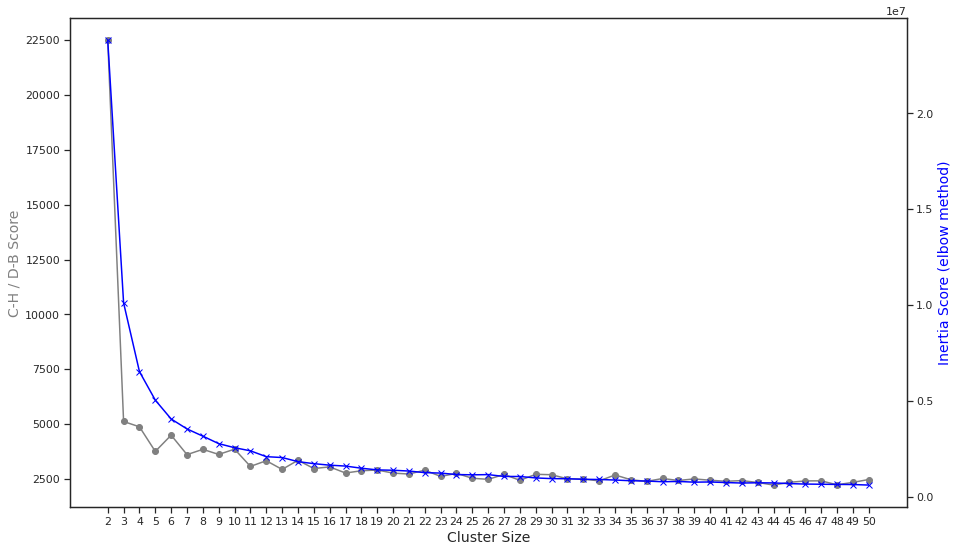

In [ ]:
# visualize the classifier performance for different values of K
fig,ax = plt.subplots(figsize=(15,9))
ax.plot(k_space, score, color="grey", marker="o",)
ax.set_xlabel("Cluster Size",fontsize=14)
ax.set_ylabel("C-H / D-B Score",fontsize=14, color='grey')
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(k_space, inertias, color="blue", marker="x")
ax2.set_ylabel("Inertia Score (elbow method)",color="blue",fontsize=14)
plt.xticks(k_space)
plt.show()

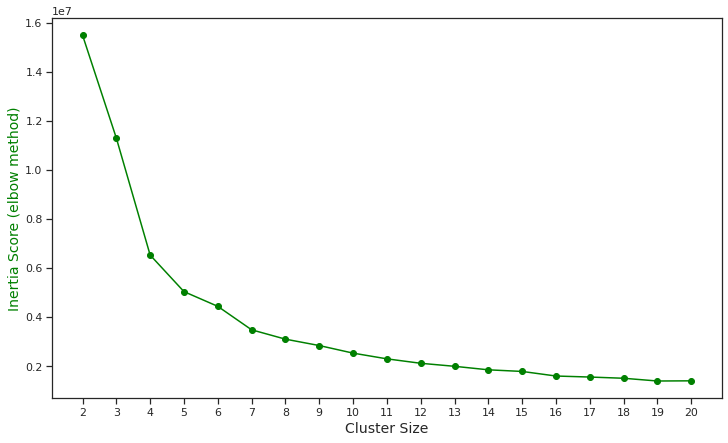

In [ ]:
# visualize the classifier performance for different values of K
fig,ax = plt.subplots(figsize=(12,7))
ax.set_xlabel("Cluster Size",fontsize=14)
ax.plot(k_space, inertias, color="green", marker="o")
ax.set_ylabel("Inertia Score (elbow method)",color="green",fontsize=14)
plt.xticks(k_space)
plt.show()

In [ ]:
# predict classes for the NFT wallets with k = best k (high C-H index, low D-B score, elbow method for inertia score)
k = 5
cla = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1).fit(X)
feature_df['class_prediction'] = list(cla.predict(X))
feature_df['class_prediction'] = feature_df['class_prediction'].astype(str)

In [ ]:
feature_df.groupby('class_prediction').describe()

total_nft_held                                           \
                          count        mean        std  min    25%   50%   
class_prediction                                                           
0                         181.0   74.436464  46.366207  8.0  38.00  62.0   
1                        1652.0    8.162228   7.794939  1.0   3.00   6.0   
2                           2.0    3.500000   3.535534  1.0   2.25   3.5   
3                         446.0   32.107623  19.738677  1.0  17.00  30.0   
4                          57.0  106.929825  68.322988  1.0  59.00  90.0   

                                total_nft_transacted                         \
                     75%    max                count        mean        std   
class_prediction                                                              
0                 112.00  211.0                181.0  167.248619  48.940543   
1                  11.00   49.0               1652.0   13.912228  11.838410   
2                   4.75    6.0                  2.0    7.000000   8.485281   
3                  43.00  113.0                446.0   70.650224  24.083723   
4                 163.00  263.0                 57.0  314.035088  85.142520   

                                                    total_nft_sale  \
                   min    25%    50%     75%    max          count   
class_prediction                                                     
0                 25.0  133.0  161.0  192.00  333.0          181.0   
1                  1.0    4.0   10.0   21.00   63.0         1652.0   
2                  1.0    4.0    7.0   10.00   13.0            2.0   
3                 14.0   52.0   66.0   86.75  156.0          446.0   
4                  2.0  264.0  309.0  368.00  494.0           57.0   

                                                                             \
                         mean         std     min      25%     50%      75%   
class_prediction                                                              
0                  137.226519   56.327698     0.0   104.00   137.0   172.00   
1                    9.461259   10.097121     0.0     1.00     6.0    15.00   
2                 1876.500000  890.247438  1247.0  1561.75  1876.5  2191.25   
3                   57.957399   26.192897     0.0    40.00    54.0    76.00   
4                  324.035088  116.092015    82.0   263.00   298.0   359.00   

                         unique_collections_held                             \
                     max                   count       mean        std  min   
class_prediction                                                              
0                  394.0                   181.0  27.613260  17.236739  1.0   
1                   54.0                  1652.0   4.707627   4.050991  1.0   
2                 2506.0                     2.0   3.000000   2.828427  1.0   
3                  147.0                   446.0  15.219731   9.782634  1.0   
4                  762.0                    57.0  37.508772  25.037203  1.0   

                                          max_collection_count             \
                   25%   50%   75%    max                count       mean   
class_prediction                                                            
0                 14.0  25.0  36.0   91.0                181.0  17.812155   
1                  2.0   3.0   6.0   25.0               1652.0   3.257869   
2                  2.0   3.0   4.0    5.0                  2.0   1.500000   
3                  8.0  13.0  21.0   68.0                446.0   8.419283   
4                 20.0  36.0  50.0  116.0                 57.0  19.403509   

                                                            \
                        std  min   25%   50%    75%    max   
class_prediction                                             
0                 22.999712  2.0  6.00  10.0  20.00  191.0   
1                  3.893817  1.0  1.00   2.0   3.00   44.0   
2                  0.

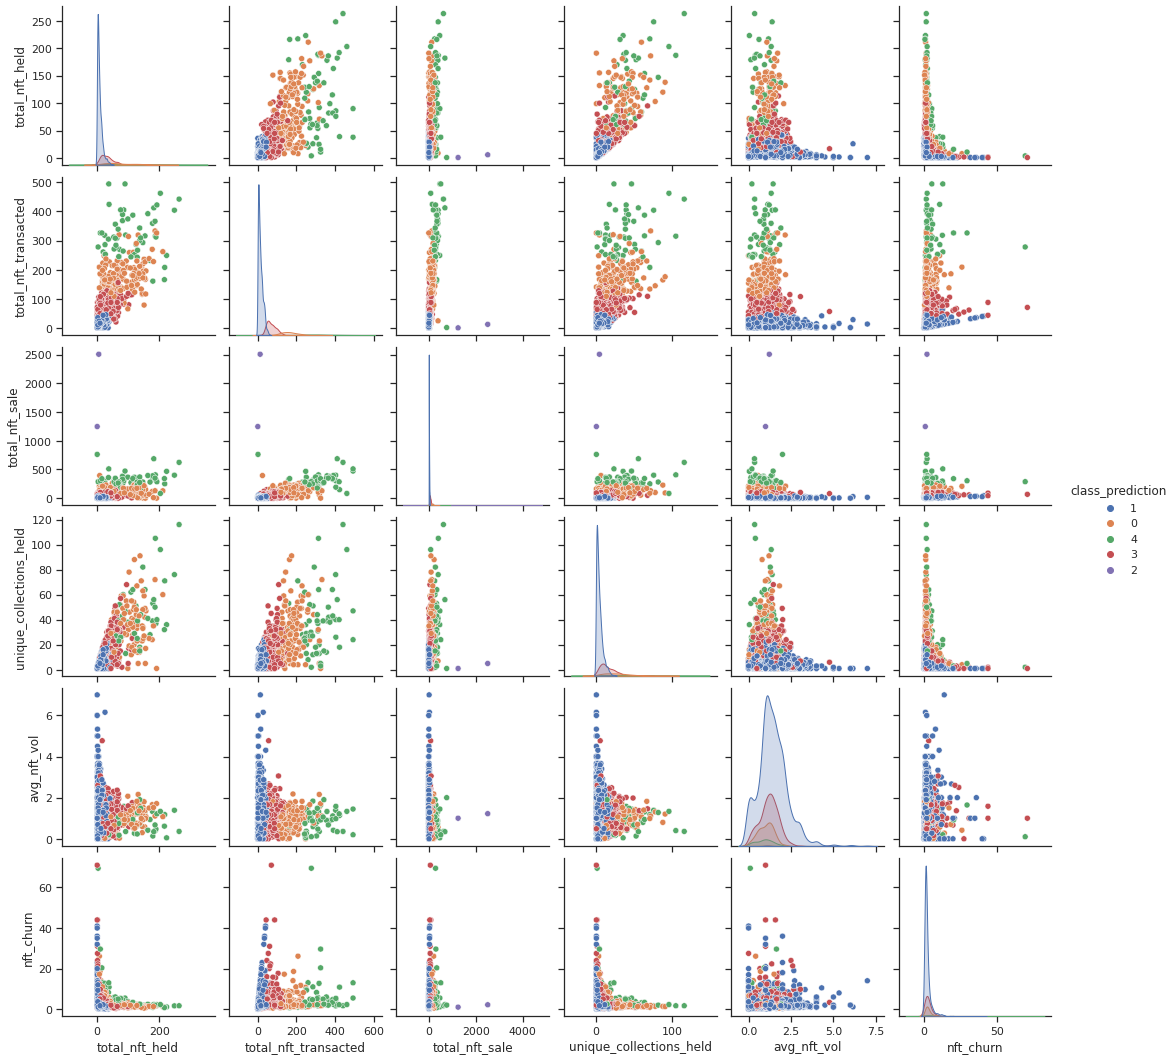

In [ ]:
#sns.set_theme(style="ticks")
sns.pairplot(feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','class_prediction','nft_churn']], hue='class_prediction')

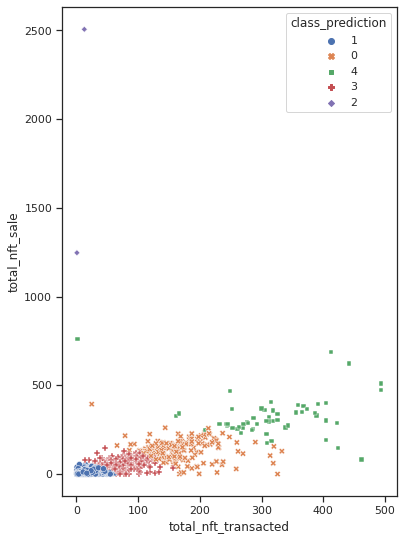

In [ ]:
x = 'total_nft_transacted'
y = 'total_nft_sale'
fig,ax = plt.subplots(figsize=(6,9))
sns.scatterplot(data=feature_df, x=x, y=y, hue="class_prediction", style="class_prediction")


### NFT Topic Modeling (Latent Semantic Indexing / Latent Dirichlet Allocation)

NFT description text pre-processing loading into vectorizer and LSI / LDA modeling


In [ ]:
def nft_text_cleaning(nft_description_list):
  # remove all non-alpha tokens (not chars) from NFT descriptions, remove stopwords (including terms "NFT and ETH")
  # import gensim stopwords corpus, add the terms "nft" and "eth" to gensim stopwords corpa as well as other low info-gain words showing up in descriptions
  # apply list comprehension to filter out stopwords per Gensims stopswords corpa
  unique_assets_filtered = [[nft_token_word for nft_token_word in nft_doc.lower().split() if (nft_token_word not in STOPWORDS.union(set(['nft', 'eth','https','s','ipfs','collection','com','www','ethereum','org','http'])) and nft_token_word.isnumeric() == False and len(nft_token_word) >3 and len(nft_token_word) < 15 )] for nft_doc in nft_description_list]

  return unique_assets_filtered

def token_count_frequency(token_list):
  # create dict with token:freq_count entries for frequency count analysis
  token_freq_dict = collections.defaultdict(int)
  for nft_desc in token_list:
    for token in nft_desc:
      token_freq_dict[token] += 1
  return token_freq_dict

In [ ]:
# generate a list of documents representing the set of cleaned NFT descriptions
w_df.asset_description = w_df.asset_description.astype(str)
unique_assets = w_df[w_df.asset_description!='None'].dropna(subset=['asset_description']).asset_description.unique()

cleaned_nft_descriptions = nft_text_cleaning(unique_assets)
token_freq = token_count_frequency(cleaned_nft_descriptions)

Analysis of NFT description Token Frequency

In [ ]:
token_freq_df = pd.DataFrame.from_dict(token_freq, orient='index', columns = ['token_count']).sort_values(by='token_count',ascending=False)
token_freq_df.token_count.describe()

count    40360.000000
mean        14.043013
std         73.349987
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       4149.000000
Name: token_count, dtype: float64

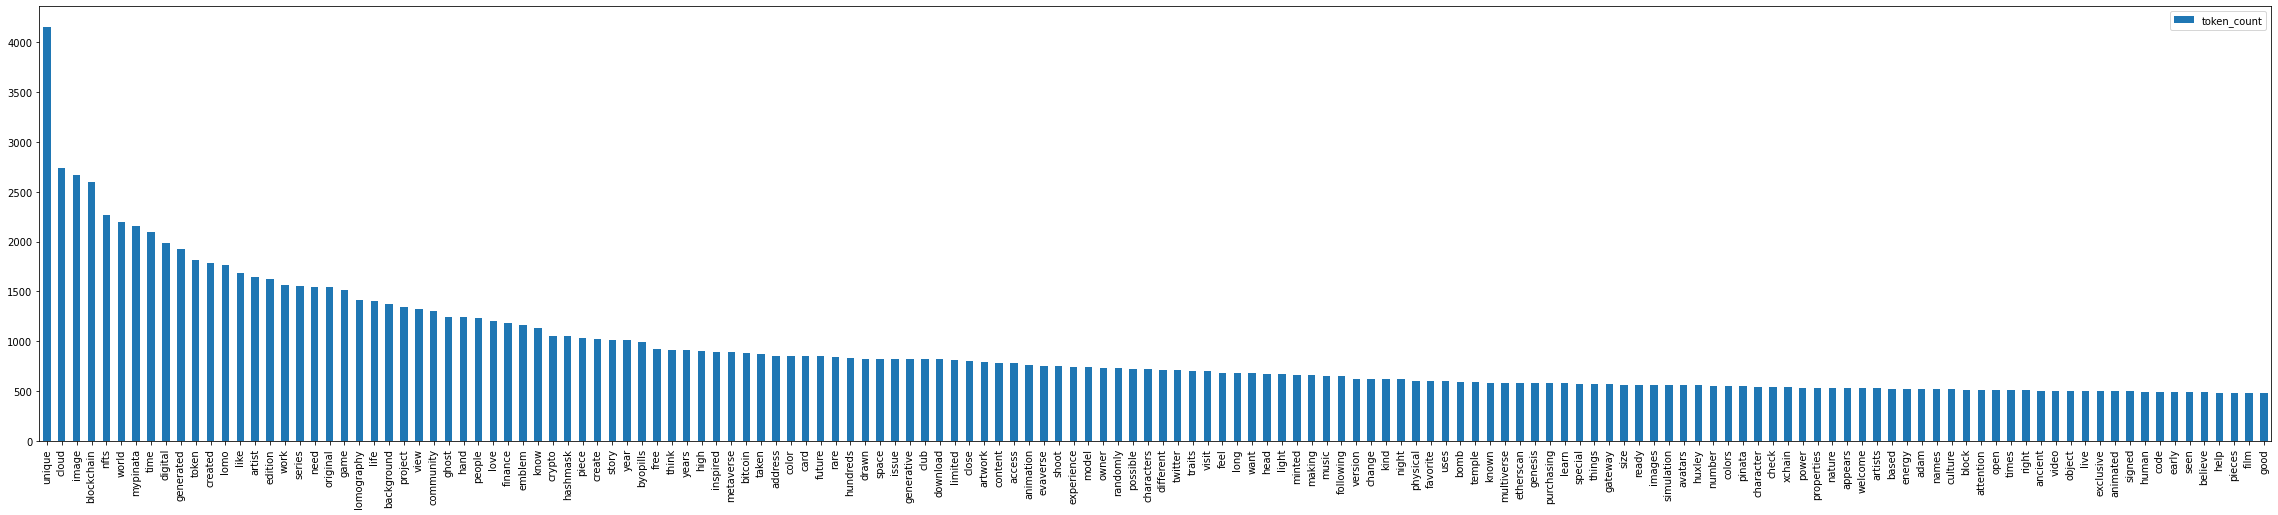

In [ ]:
token_freq_df.head(150).plot.bar(figsize=(40,8))

In [ ]:
# apply list comprehension to filter tokens with a count above / below a defined threshold from unique_assets
min_token_cnt = 100 # remove words that appear < 10 times
max_token_cnt = 10000 # remove words that appear > 10000 times
unique_assets_filtered = [[token for token in nft_desc.split(' ') if (token_freq[token] > min_token_cnt and token_freq[token] < max_token_cnt)] for nft_desc in unique_assets]

In [ ]:
gensim_dict = corpora.Dictionary(unique_assets_filtered)
corpus = [gensim_dict.doc2bow(nft_desc) for nft_desc in unique_assets_filtered]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
lsi_coherence_scores = {}
lda_coherence_scores = {}
for n_topics in list(np.linspace(5,100,20)):
  lsi_model = models.LsiModel(corpus_tfidf, id2word=gensim_dict, num_topics=n_topics)
  lda_model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=n_topics)
  for model in [lsi_model,lda_model]:
    coherence_mod = CoherenceModel(model=model, corpus=corpus, coherence='c_v', texts=unique_assets_filtered)
    if model == lsi_model:
      lsi_coherence_scores["{} topics".format(n_topics)] = coherence_mod.get_coherence()  # append dict with lsi coherence score
    else:
      lda_coherence_scores["{} topics".format(n_topics)] = coherence_mod.get_coherence()  # append dict with lda coherence score

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:193: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [mat, np.matrix(np.zeros((rows, padcol)))],
/usr/local/lib/python3.7/dist-packages/numpy/matrixlib/defmatrix.py:1109: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(concatenate(arr_rows, axis=0))


In [ ]:
lsi_scores_df = pd.DataFrame.from_dict(lsi_coherence_scores, orient='index', columns=['lsi_coherence_scores'])
lda_scores_df = pd.DataFrame.from_dict(lda_coherence_scores, orient='index', columns=['lda_coherence_scores'])
pd.merge(lsi_scores_df, lda_scores_df, how='left', left_index=True, right_index=True)

In [ ]:
pyLDAvis.enable_notebook()
ldamodel_highcv = models.LdaModel(corpus, id2word=gensim_dict, num_topics=100)
vis = pyLDAvis.gensim_models.prepare(ldamodel_highcv, corpus, gensim_dict)
vis

### Topic Modeling EDA

In [ ]:
min_trait_count = 500
trait_df['trait_type'] = trait_df['trait_type'].apply(lambda x: str(x).lower())
trait_df['value'] = trait_df['value'].apply(lambda x: str(x).lower()) 
trait_pivot = pd.pivot_table(index='value',columns='trait_type',aggfunc=np.size, data=trait_df[['trait_type','value']], margins=True).fillna(0)
trait_pivot = trait_pivot[(trait_pivot['All'] > min_trait_count)].transpose()
trait_pivot = trait_pivot[(trait_pivot['All'] > min_trait_count)].drop(['All','na'], axis=1).drop(['All'],axis=0)
rows_sort=trait_pivot.max(axis=1).sort_values(ascending=False).index
col_sort=trait_pivot.max().sort_values(ascending=False).index
trait_pivot.loc[rows_sort,col_sort]

value,none,yes,26,1,0,black,white,4,geometric triangles,3,2,green,blue,orange,yellow,purple,pink,unrevealed,coming soon!,gift goat
trait_type,,,,,,,,,,,,,,,,,,,,
none,20384.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hidden,0.0,2462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
atomic number,0.0,0.0,1832.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
stable ratio,0.0,0.0,0.0,1712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
head,1572.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,324.0,28.0,268.0,292.0,320.0,300.0,0.0,0.0,0.0
symmetry,0.0,0.0,0.0,1458.0,812.0,0.0,0.0,0.0,0.0,0.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cheeks,1412.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,0.0
fractal bend,0.0,0.0,0.0,104.0,1288.0,0.0,0.0,406.0,0.0,326.0,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
convergency amount,0.0,0.0,0.0,556.0,1256.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
trait_df[trait_df.trait_type == '1 of 1']

,asset_token_id,image_url,image_preview_url,image_thumbnail_url,name,description,external_link,created_date,permalink,creator_username,creator_profile_image,payment_symbol,num_sales,collection_name,price,trait_type,value,trait_count
70111,340590982,https://lh3.googleusercontent.com/1J9qY4mFvfTI...,https://lh3.googleusercontent.com/1J9qY4mFvfTI...,https://lh3.googleusercontent.com/1J9qY4mFvfTI...,Lil Pluto #3283,Pluto HipHop Dept.,,2022-02-22 09:37:05.046674,https://opensea.io/assets/0x231e7ebe082dc9cb6c...,None,https://storage.googleapis.com/opensea-static/...,,0,Pluto HipHop Dept. V2,-1,1 of 1,MBK,0.0
116279,340590987,https://lh3.googleusercontent.com/Qv5Z6fo2VlQG...,https://lh3.googleusercontent.com/Qv5Z6fo2VlQG...,https://lh3.googleusercontent.com/Qv5Z6fo2VlQG...,Lil Pluto #3284,Pluto HipHop Dept.,,2022-02-22 09:37:05.046674,https://opensea.io/assets/0x231e7ebe082dc9cb6c...,None,https://storage.googleapis.com/opensea-static/...,,0,Pluto HipHop Dept. V2,-1,1 of 1,FatFlowBoy,0.0


### Other Code (placeholder)
- BUILD DATABASE OF OS IMAGES TO TRAIN A CNN

In [ ]:
# join trait df with transaction df - could not find matches for asset_token_id field between the datasets
#w_df[w_df.asset_collection_name.isin(trait_df.collection_name.to_list())]#.asset_collection_name.nunique()

In [ ]:
# # first get the image URL from OS
# # helper func to get the nft asset image url file
# def get_nft_image_url(token_id,asset_contract_address):
#   url = "https://api.opensea.io/api/v1/assets?token_ids={}&order_by=pk&order_direction=desc&asset_contract_address={}&limit=20&include_orders=true".format(token_id,asset_contract_address)
#   headers = {"Accept": "application/json","X-API-KEY": "d4222f42fc6c4a79a3883926a81c4a95"}
#   response = requests.request("GET", url, headers=headers)
#   nft_image_url = dict(response.json())['assets'][0]['image_url']
#   return nft_image_url

# pd.set_option('display.max_rows',250)
# df.iloc[500000].asset_asset_contract_address

# token_id = '93751882162263358060651260285234307757752326041288358141288876844389834424321'
# contract_address = '0x495f947276749ce646f68ac8c248420045cb7b5e'

# get_nft_image_url(token_id,contract_address)


# BUILD DATABASE OF OS NFT IMAGES
# BELOW GENERATES LINKS TO OS IMAGE FOR EACH RECORD IN DATABASE

# # set directory to output folder
# os.chdir('/content/nft_images')
# # get the unique set of nft asset ids and contract addresses
# nft_lookup = list(df[['asset_token_id','asset_asset_contract_address']].to_records(index=False))

# tokens = []
# for nft_record in nft_lookup[0:1000]:  
#   token_id = str(nft_record[0])
#   contract_address = str(nft_record[1])

#   # need to build in a way to assess whether we already have an nft image based on CSV log!
#   # if we do not already have token then append existing log with new images
#   # existing_token_images = pd.read_csv()
#   try:
#     url = get_nft_image_url(token_id,contract_address)
#     urllib.request.urlretrieve("{}".format(url), "{}_{}.jpg".format(token_id,contract_address))
#     tokens.append((token_id,contract_address))
#   except:
#     pass
  
# payload = pd.DataFrame(tokens, columns=['token_id', 'token_contract_address'])
# payload.to_csv('nft_image_payload_20220304.csv',index=False)
# print('stopped at record {}'.format(nft_record))

# zip the images folder for download
# !zip -r /content/nft_images.zip /content/nft_images

# from google.colab import files
# files.download("/content/nft_images.zip")

In [ ]:
# def vect_build(arr, vectorizer, max_features, ngram_range, min_df, max_df):
#     vect = vectorizer(max_features = max_features, lowercase = True, ngram_range = ngram_range, min_df = min_df, max_df = max_df, stop_words = 'english')
#     fitted_vect = vect.fit_transform(arr)
#     feature_names = vect.get_feature_names_out()
#     return fitted_vect,feature_names

# def lsi_model(X, n_topics):
#   # LSI does truncated SVD on the doc-term matrix of tf.idf term-weights
#   # The matrix we got back from the vectorizer is a 
#   # document-term matrix, i.e. one row per document
#   lsi = TruncatedSVD(n_components=n_topics)
#   reduced_term_matrix = lsi.fit_transform(X)
#   return reduced_term_matrix

# # WIP ...
# # def lsi_model_terms(X,n_topics):
# #   terms = tfidf.get_feature_names()
# #   for index, component in enumerate(lsa.components_):
# #       zipped = zip(terms, component)
# #       top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
# #       top_terms_list=list(dict(top_terms_key).keys())
# #       print("Topic "+str(index)+": ",top_terms_list)
# # ... WIP

# def lda_model(X, num_topics):
#   lda = LatentDirichletAllocation(n_components = num_topics)
#   lda_mod = lda.fit_transform(X)

#   # lda log likelihood (higher=better)
#   ll_eval = lda.score(X)
#   # perplexity (lower = better)
#   p_eval = lda.perplexity(X)

#   return lda_mod,ll_eval,p_eval

In [ ]:
# log_liklihood_scores = {}
# perplexity_scores = {}

# for x in [100,1000,10000]: # vary the vectorizer max_feature size by order of magnitude
#   for y in [10,100,1000,10000]: # vary the num_topics by order of magnitude
#     X = vect_build(unique_assets, CountVectorizer, x, (1,2), 2, 0.95)
#     result = lda_model(X[0],y)
#     log_liklihood_scores['{}_{}'.format(x,y)] = result[1]
#     perplexity_scores['{}_{}'.format(x,y)] = result[2]

# # save scores to text files

# with open('log_liklihood2.txt', 'w') as log_liklihood:
#      log_liklihood.write(json.dumps(log_liklihood_scores))
# with open('perp_scores2.txt', 'w') as perp_output:
#     perp_output.write(json.dumps(perplexity_scores))

In [ ]:
# LSI (use tfidf vectorizer)
X = vect_build(unique_assets, TfidfVectorizer, 10000, (1,2), 2, 0.95)
lsi_topics = lsi_model(X[0],1000)

# LDA (use countvectorizer)
X = vect_build(unique_assets, CountVectorizer, 10000, (1,2), 2, 0.95)
#lda_topics = lda_model(X[0],1000)